<h1 align=center>Underwater Object Detection for Submarines</h1>

---
## Problem Statement
Rescue missions in underwater environments, particularly those involving submarines, face significant challenges due to the unique and visually complex nature of underwater imagery. Identifying human bodies accurately and efficiently in such conditions is crucial for successful rescue operations. However, existing datasets and models often fail to account for the distinct visual characteristics of underwater environments, such as low visibility, distortion, and the presence of debris.

This project aimed to develop a robust object detection system using bounding boxes to locate humans in underwater environments. The goal was to improve the accuracy and reliability of human detection in real-time scenarios, facilitating faster response times and increasing the likelihood of successful rescues. By leveraging state-of-the-art deep learning techniques and innovative data preprocessing strategies, this project addressed the limitations of existing models and datasets, creating a tailored solution for submarine rescue missions.


In [1]:
import os
import cv2
import torch
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from ultralytics import YOLO

### Data Preporcessing

---
The data preprocessing stage involved basic adjustments to prepare the dataset for training, validation, and testing. Since the YOLOv11 model has built-in capabilities for further preprocessing, most of the heavy lifting was handled by the model. Below is an overview of the key steps taken:

1. **Dataset Combination and Resplitting**
    * Initial Problem
        * The original validation and test sets were too small, leading to imbalanced splits and potential issues during training and evaluation.
    * Solution
        * Combined the original training, validation, and test sets into a single dataset.
        * Re-split the combined dataset into new subsets with the desired ratios:
            * Train Set: 70%
            * Validation Set: 20%
            * Test Set: 10%
1. **Bounding Box Adjustment**
    * For Images without humans:
        * Updated the bounding box coordinates to (0, 0, 0, 0) to ensure non-human objects were ignored during training.
        * his step helped the model focus on detecting humans in underwater environments without being distracted by irrelevant objects.
1. **Model-Handled Preprocessing**
    * All additional preprocessing steps (such as resizing, normalization, and data augmentation) were handled directly by the YOLOv11 model.
    * The model automatically managed input scaling, anchor box adjustments, and other preprocessing tasks, simplifying the workflow.

In [5]:
# Paths
data_dir = "data/drowning_copy"
image_dir = os.path.join(data_dir, "all_images")
label_dir = os.path.join(data_dir, "all_labels")

# Combine all images and labels into one folder
def combine_data(data_dir, image_dir, label_dir):
    """
    Combines the images and labels into 2 folders in the same directory
    """
    os.makedirs(image_dir, exist_ok=True)
    os.makedirs(label_dir, exist_ok=True)

    # Subdirectories to process
    subdirs = ["train", "valid", "test"]

    for subdir in subdirs:
        sub_image_dir = os.path.join(data_dir, subdir, "images")
        sub_label_dir = os.path.join(data_dir, subdir, "labels")

        for image_fname in os.listdir(sub_image_dir):
            # Copy image
            shutil.copy(os.path.join(sub_image_dir, image_fname), os.path.join(image_dir, image_fname))

            # Match corresponding label file
            base_name = os.path.splitext(image_fname)[0]  # Get the base name (without extension)
            label_fname = f"{base_name}.txt"  # Assuming labels have a `.txt` extension
            label_path = os.path.join(sub_label_dir, label_fname)

            if os.path.exists(label_path):
                shutil.copy(label_path, os.path.join(label_dir, label_fname))
            else:
                print(f"Warning: Label file not found for image {image_fname}")

# Combine all data
combine_data(data_dir, image_dir, label_dir)

In [ ]:
# Split into new train, validation, and test sets
def split_data(image_dir, label_dir, output_dir, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    """
    Split the data into desired ratios
    """
    # Ensure ratios add up to 1
    assert train_ratio + val_ratio + test_ratio == 1, "Ratios must sum to 1."

    # Create output directories
    splits = ["train", "valid", "test"]
    for split in splits:
        os.makedirs(os.path.join(output_dir, split, "images"), exist_ok=True)
        os.makedirs(os.path.join(output_dir, split, "labels"), exist_ok=True)

    # Get all filenames
    image_files = sorted(os.listdir(image_dir))
    label_files = sorted(os.listdir(label_dir))

    # Match image and label files by base name
    image_base_names = [os.path.splitext(fname)[0] for fname in image_files]
    label_base_names = [os.path.splitext(fname)[0] for fname in label_files]

    # Ensure every image has a corresponding label
    matched_files = [
        (image_files[i], f"{image_base_names[i]}.txt")
        for i in range(len(image_files))
        if image_base_names[i] in label_base_names
    ]

    # Extract matched filenames
    image_files = [image for image, label in matched_files]
    label_files = [label for image, label in matched_files]

    # Split filenames
    train_images, temp_images, train_labels, temp_labels = train_test_split(
        image_files, label_files, test_size=val_ratio + test_ratio, random_state=42
    )
    val_images, test_images, val_labels, test_labels = train_test_split(
        temp_images, temp_labels, test_size=test_ratio / (val_ratio + test_ratio), random_state=42
    )

    # Helper to move files
    def move_files(file_list, source_dir, target_dir):
        for fname in file_list:
            shutil.move(os.path.join(source_dir, fname), os.path.join(target_dir, fname))

    # Move files into respective folders
    move_files(train_images, image_dir, os.path.join(output_dir, "train", "images"))
    move_files(train_labels, label_dir, os.path.join(output_dir, "train", "labels"))

    move_files(val_images, image_dir, os.path.join(output_dir, "valid", "images"))
    move_files(val_labels, label_dir, os.path.join(output_dir, "valid", "labels"))

    move_files(test_images, image_dir, os.path.join(output_dir, "test", "images"))
    move_files(test_labels, label_dir, os.path.join(output_dir, "test", "labels"))

    print(f"Data split completed:")
    print(f"Train: {len(train_images)} images")
    print(f"Validation: {len(val_images)} images")
    print(f"Test: {len(test_images)} images")

# Perform the split
image_dir = "data/drowning_copy/all_images"
label_dir = "data/drowning_copy/all_labels"
output_dir = "data/drowning_resplit"
split_data(image_dir, label_dir, output_dir)


Data split completed:
Train: 1917 images
Validation: 639 images
Test: 639 images


In [ ]:
# Directory structure
base_dir = "data/drowning_test"
subdirs = ["train", "valid", "test"]

def preprocess_labels(base_dir, subdirs):
    """
    Reset the bounding box of the non-human images to 0,0,0,0
    """
    for subdir in subdirs:
        label_path = os.path.join(base_dir, subdir, "labels")
        for file_name in os.listdir(label_path):
            file_path = os.path.join(label_path, file_name)
            with open(file_path, "r") as f:
                lines = f.readlines()
            
            new_lines = []
            for line in lines:
                class_id, x_center, y_center, width, height = map(float, line.split())
                if int(class_id) == 1:  # If class is Human Not Present
                    x_center, y_center, width, height = 0, 0, 0, 0
                new_lines.append(f"{int(class_id)} {x_center} {y_center} {width} {height}\n")
            
            with open(file_path, "w") as f:
                f.writelines(new_lines)

# Preprocess the labels
preprocess_labels(base_dir, subdirs)

### Modeling

---

In [ ]:
# Create a model instance with the pretrained weights
model1 = YOLO("yolo11n.pt")

In [ ]:
# Train the model on our dataset
model1.train(data='custom-data.yaml', epochs=50, optimizer='adam', verbose=True)

New https://pypi.org/project/ultralytics/8.3.40 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.29 🚀 Python-3.10.12 torch-2.5.0 MPS (Apple M2 Pro)
engine/trainer: task=detect, mode=train, model=runs/detect/train53/weights/best.pt, data=custom-data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=mps, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=

train: Scanning /Users/gagandeepsingh/Documents/_RRC/2024_FALL/COMP 3704/Project/Data/drowning_resplit/train/labels.cache... 1917 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1917/1917 [00:00<?, ?it/s]

train: WARNING ⚠️ /Users/gagandeepsingh/Documents/_RRC/2024_FALL/COMP 3704/Project/Data/drowning_resplit/train/images/FishDataset0_png_jpg.rf.b883f39e065f464e23675dd22fac0ac3.jpg: 3 duplicate labels removed
train: WARNING ⚠️ /Users/gagandeepsingh/Documents/_RRC/2024_FALL/COMP 3704/Project/Data/drowning_resplit/train/images/FishDataset101_png_jpg.rf.0a96ed67a4ca25a3b5da499e48ed6171.jpg: 4 duplicate labels removed
train: WARNING ⚠️ /Users/gagandeepsingh/Documents/_RRC/2024_FALL/COMP 3704/Project/Data/drowning_resplit/train/images/FishDataset101_png_jpg.rf.e19004d4c6e60919ce1ba339d94f311f.jpg: 4 duplicate labels removed
train: WARNING ⚠️ /Users/gagandeepsingh/Documents/_RRC/2024_FALL/COMP 3704/Project/Data/drowning_resplit/train/images/FishDataset104_png_jpg.rf.db6e1e013bdcfa5e54b802f371f077f9.jpg: 1 duplicate labels removed
train: WARNING ⚠️ /Users/gagandeepsingh/Documents/_RRC/2024_FALL/COMP 3704/Project/Data/drowning_resplit/train/images/FishDataset108_png_jpg.rf.1fd8e5974122f952603797

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


/Users/gagandeepsingh/anaconda3/envs/DL2/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
val: Scanning /Users/gagandeepsingh/Documents/_RRC/2024_FALL/COMP 3704/Project/Data/drowning_resplit/valid/labels.cache... 639 images, 0 backgrounds, 0 corrupt: 100%|██████████| 639/639 [00:00<?, ?it/s]

val: WARNING ⚠️ /Users/gagandeepsingh/Documents/_RRC/2024_FALL/COMP 3704/Project/Data/drowning_resplit/valid/images/FishDataset104_png_jpg.rf.a0275c7e55a800128fc2f9bf2eefd276.jpg: 1 duplicate labels removed
val: WARNING ⚠️ /Users/gagandeepsingh/Documents/_RRC/2024_FALL/COMP 3704/Project/Data/drowning_resplit/valid/images/FishDataset110_png_jpg.rf.42d4a4b59b4a46293ed85d2b3977ca6b.jpg: 2 duplicate labels removed
val: WARNING ⚠️ /Users/gagandeepsingh/Documents/_RRC/2024_FALL/COMP 3704/Project/Data/drowning_resplit/valid/images/FishDataset112_png_jpg.rf.466550a71c7e4b72ea36331f66137b63.jpg: 8 duplicate labels removed
val: WARNING ⚠️ /Users/gagandeepsingh/Documents/_RRC/2024_FALL/COMP 3704/Project/Data/drowning_resplit/valid/images/FishDataset116_png_jpg.rf.1dfcabf5097ce05c63b2ec6f6f7e1d96.jpg: 4 duplicate labels removed
val: WARNING ⚠️ /Users/gagandeepsingh/Documents/_RRC/2024_FALL/COMP 3704/Project/Data/drowning_resplit/valid/images/FishDataset118_png_jpg.rf.99dc9c54ec53236d652d81b755f633

Plotting labels to runs/detect/train6/labels.jpg... 
optimizer: Adam(lr=0.01, momentum=0.937) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train6
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.89G      1.711      1.393      1.679         11        640: 100%|██████████| 120/120 [02:10<00:00,  1.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/20 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  15%|█▌        | 3/20 [00:26<02:19,  8.21s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 10/20 [01:01<00:44,  4.40s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [01:38<00:00,  4.91s/it]


                   all        639        720      0.409      0.343       0.39      0.214

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      5.09G      1.693       1.39      1.659         15        640: 100%|██████████| 120/120 [02:19<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:26<00:00,  1.32s/it]


                   all        639        720      0.322       0.26       0.31      0.108

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      5.42G      1.785      1.463      1.748         15        640: 100%|██████████| 120/120 [02:17<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:41<00:00,  2.07s/it]


                   all        639        720      0.248      0.282      0.252      0.102

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      5.71G      1.786      1.503      1.719          6        640: 100%|██████████| 120/120 [02:49<00:00,  1.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/20 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   5%|▌         | 1/20 [00:08<02:48,  8.88s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 2/20 [00:18<02:44,  9.16s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  15%|█▌        | 3/20 [00:27<02:33,  9.05s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 4/20 [00:36<02:28,  9.25s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  25%|██▌       | 5/20 [00:44<02:11,  8.79s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  35%|███▌      | 7/20 [00:59<01:42,  7.91s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 8/20 [01:05<01:30,  7.52s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  45%|████▌     | 9/20 [01:12<01:20,  7.28s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  55%|█████▌    | 11/20 [01:27<01:06,  7.38s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  60%|██████    | 12/20 [01:36<01:02,  7.80s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  65%|██████▌   | 13/20 [01:44<00:56,  8.07s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  70%|███████   | 14/20 [01:54<00:50,  8.43s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  85%|████████▌ | 17/20 [02:14<00:21,  7.01s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [02:35<00:00,  7.77s/it]


                   all        639        720      0.251      0.209      0.192     0.0977

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      5.98G      1.786      1.406      1.681         19        640: 100%|██████████| 120/120 [03:05<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:37<00:00,  1.86s/it]


                   all        639        720      0.368      0.357       0.39       0.21

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      6.29G      1.761      1.481      1.713         23        640: 100%|██████████| 120/120 [03:41<00:00,  1.85s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:35<00:00,  1.80s/it]


                   all        639        720      0.364      0.368       0.39      0.191

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      6.59G      1.722      1.381      1.654         16        640: 100%|██████████| 120/120 [03:36<00:00,  1.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:26<00:00,  1.32s/it]


                   all        639        720      0.358      0.339      0.378      0.165

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      6.83G      1.744      1.373      1.691         14        640: 100%|██████████| 120/120 [03:25<00:00,  1.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:49<00:00,  2.48s/it]


                   all        639        720       0.41      0.358      0.406      0.214

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      7.13G       1.74      1.415      1.675         10        640: 100%|██████████| 120/120 [03:55<00:00,  1.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:43<00:00,  2.16s/it]


                   all        639        720      0.357      0.363      0.371        0.2

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      7.45G       1.69      1.371      1.644         14        640: 100%|██████████| 120/120 [05:02<00:00,  2.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/20 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   5%|▌         | 1/20 [00:08<02:47,  8.83s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  10%|█         | 2/20 [00:14<02:09,  7.18s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  15%|█▌        | 3/20 [00:22<02:08,  7.55s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  20%|██        | 4/20 [00:28<01:48,  6.77s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  35%|███▌      | 7/20 [00:53<01:40,  7.72s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 8/20 [01:00<01:31,  7.64s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  45%|████▌     | 9/20 [01:07<01:21,  7.45s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  55%|█████▌    | 11/20 [01:20<01:00,  6.74s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  60%|██████    | 12/20 [01:26<00:52,  6.61s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  65%|██████▌   | 13/20 [01:36<00:52,  7.50s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  70%|███████   | 14/20 [01:50<00:57,  9.58s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  85%|████████▌ | 17/20 [02:07<00:20,  6.77s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  90%|█████████ | 18/20 [02:14<00:13,  6.95s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [02:28<00:00,  7.41s/it]


                   all        639        720      0.339      0.212      0.212      0.127

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      7.79G      1.678      1.372      1.642          9        640: 100%|██████████| 120/120 [06:14<00:00,  3.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:43<00:00,  2.18s/it]


                   all        639        720      0.381      0.374      0.408      0.209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      8.06G      1.669       1.29      1.609         21        640: 100%|██████████| 120/120 [06:44<00:00,  3.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:33<00:00,  1.67s/it]


                   all        639        720      0.413      0.404      0.442      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      8.49G      1.645      1.303      1.605         12        640: 100%|██████████| 120/120 [07:02<00:00,  3.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   5%|▌         | 1/20 [00:04<01:20,  4.23s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  35%|███▌      | 7/20 [00:22<00:36,  2.83s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  40%|████      | 8/20 [00:27<00:41,  3.44s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [01:03<00:00,  3.17s/it]


                   all        639        720       0.41      0.371      0.412      0.247

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      8.76G      1.624      1.264      1.608         13        640: 100%|██████████| 120/120 [07:22<00:00,  3.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:27<00:00,  1.36s/it]


                   all        639        720      0.413      0.399      0.447      0.274

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50       9.2G      1.612      1.287      1.581         12        640: 100%|██████████| 120/120 [07:38<00:00,  3.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


                   all        639        720      0.421      0.407      0.449      0.268

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      9.55G      1.582      1.274      1.557         15        640: 100%|██████████| 120/120 [08:24<00:00,  4.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   5%|▌         | 1/20 [00:02<00:44,  2.33s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


                   all        639        720      0.397      0.371      0.403      0.209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      9.91G      1.601      1.285      1.569         18        640: 100%|██████████| 120/120 [09:06<00:00,  4.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]


                   all        639        720      0.416      0.414      0.449      0.271

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      10.3G      1.567      1.231      1.557          8        640: 100%|██████████| 120/120 [08:21<00:00,  4.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:40<00:00,  2.04s/it]


                   all        639        720      0.394      0.413      0.426      0.242

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      10.6G      1.559      1.248      1.538         17        640: 100%|██████████| 120/120 [08:51<00:00,  4.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:22<00:00,  1.12s/it]


                   all        639        720      0.448       0.41      0.451      0.279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      10.9G      1.577      1.226      1.556         13        640: 100%|██████████| 120/120 [08:16<00:00,  4.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:21<00:00,  1.06s/it]


                   all        639        720       0.41      0.385      0.423      0.234

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      11.3G      1.563      1.221      1.539         18        640: 100%|██████████| 120/120 [08:59<00:00,  4.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:19<00:00,  1.00it/s]


                   all        639        720      0.438      0.418      0.458      0.293

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      11.6G      1.518      1.194      1.536         12        640: 100%|██████████| 120/120 [09:48<00:00,  4.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  60%|██████    | 12/20 [00:14<00:08,  1.05s/it]

WARNING ⚠️ NMS time limit 3.600s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


                   all        639        720       0.42      0.427      0.459      0.288

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50        12G      1.503      1.174      1.509         18        640: 100%|██████████| 120/120 [08:08<00:00,  4.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


                   all        639        720      0.437      0.411      0.456      0.267

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      12.3G      1.463      1.142      1.482         17        640: 100%|██████████| 120/120 [09:05<00:00,  4.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:17<00:00,  1.16it/s]


                   all        639        720      0.443       0.41      0.445      0.272

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      12.7G      1.437      1.105       1.47         15        640: 100%|██████████| 120/120 [08:42<00:00,  4.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:17<00:00,  1.14it/s]


                   all        639        720      0.426      0.441      0.459      0.283

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50        13G      1.476      1.163      1.479         12        640: 100%|██████████| 120/120 [10:20<00:00,  5.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:22<00:00,  1.14s/it]


                   all        639        720      0.412      0.347      0.401      0.226

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      13.4G      1.492      1.159      1.504         30        640: 100%|██████████| 120/120 [10:22<00:00,  5.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:21<00:00,  1.09s/it]


                   all        639        720      0.445      0.432      0.467      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      13.6G      1.466      1.101      1.469         17        640: 100%|██████████| 120/120 [11:11<00:00,  5.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:16<00:00,  1.18it/s]


                   all        639        720      0.432      0.424      0.452      0.283

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50        14G      1.425      1.104      1.467         11        640: 100%|██████████| 120/120 [12:24<00:00,  6.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:22<00:00,  1.12s/it]


                   all        639        720       0.44      0.433      0.468      0.313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      14.3G      1.451        1.1      1.465         14        640: 100%|██████████| 120/120 [12:46<00:00,  6.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:22<00:00,  1.12s/it]


                   all        639        720      0.462      0.444      0.463      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      14.6G      1.382      1.121      1.445         11        640:  40%|████      | 48/120 [04:48<06:54,  5.76s/it]

### Model Evaluation

---

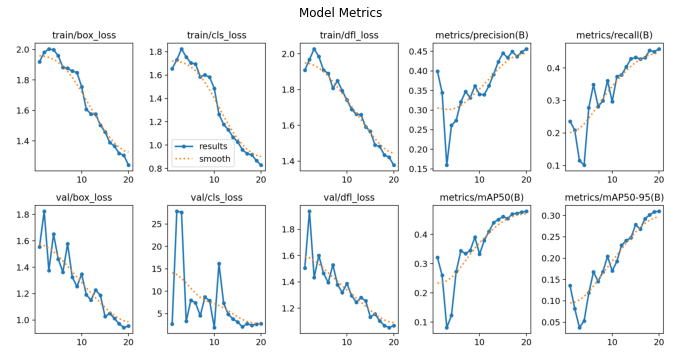

In [ ]:
# Load the images using OpenCV
img_path = "runs/detect/train53/results.png"
img = cv2.imread(img_path)

# Convert the images from BGR (OpenCV default) to RGB (Matplotlib default)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 20))
plt.imshow(img)

# Adjust layout and show the images
plt.title("Model Metrics")
plt.tight_layout()
plt.axis('off')
plt.show()


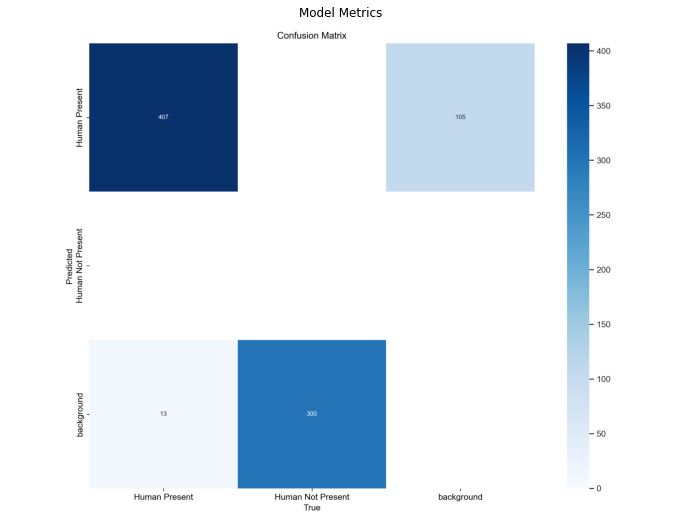

In [21]:
# Load the images using OpenCV
img_path = "runs/detect/train53/confusion_matrix.png"
img = cv2.imread(img_path)

# Convert the images from BGR (OpenCV default) to RGB (Matplotlib default)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 20))
plt.imshow(img)

# Adjust layout and show the images
plt.title("Model Metrics")
plt.tight_layout()
plt.axis('off')
plt.show()


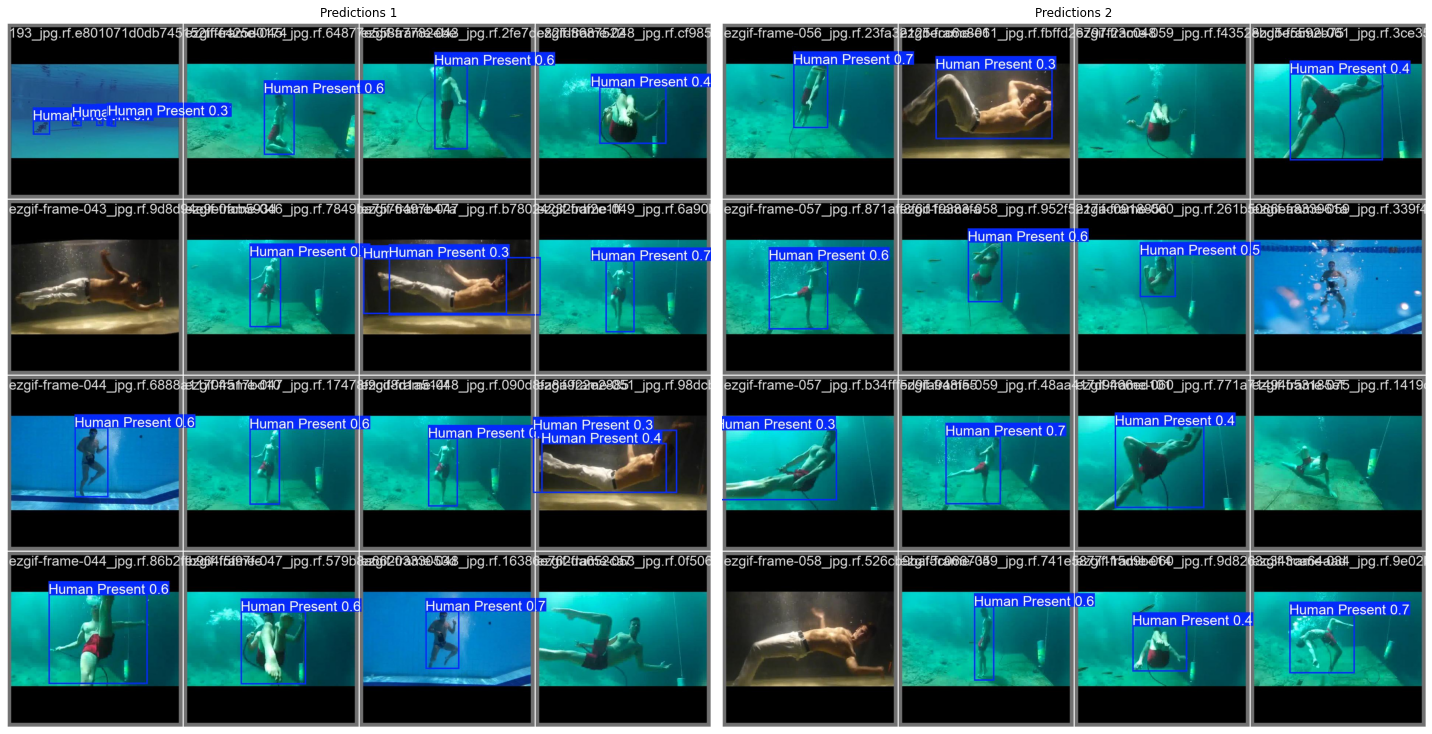

In [7]:
# Load the images using OpenCV
image1_path = "runs/detect/train10/val_batch0_pred.jpg"
image2_path = "runs/detect/train10/val_batch2_pred.jpg"

image1 = cv2.imread(image1_path)
image2 = cv2.imread(image2_path)

# Convert the images from BGR (OpenCV default) to RGB (Matplotlib default)
image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 40))  # 1 row, 2 columns

# Display the first image
axes[0].imshow(image1)
axes[0].axis("off")  # Turn off axes for a clean look
axes[0].set_title("Predictions 1")  # Optional: Add a title

# Display the second image
axes[1].imshow(image2)
axes[1].axis("off")  # Turn off axes for a clean look
axes[1].set_title("Predictions 2")  # Optional: Add a title

# Adjust layout and show the images
plt.tight_layout()
plt.show()

---

<h1 align=center>END</h1